In [ ]:
# only necessary for google colab! to load models into session
# !git clone https://github.com/jyjblrd/S4_Slicer
# !mv S4_Slicer/* ./

In [2]:
!pip install tetgen
!pip install pyvista
!pip install scipy
!pip install open3d
!pip install pygcode
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or dire

In [1]:
import networkx as nx
import numpy as np
import pyvista as pv
import tetgen
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import time
import pickle
import base64
pv.set_jupyter_backend('static') # Google colab only allows static rendering. Download and run notepad locally to view in 3D!
pv.global_theme.notebook = True
pv.start_xvfb()

def encode_object(obj):
    return base64.b64encode(pickle.dumps(obj)).decode('utf-8')

def decode_object(encoded_str):
    return pickle.loads(base64.b64decode(encoded_str))

up_vector = np.array([0, 0, 1])

# Load mesh
model_name = "pi 3mm"
mesh = o3d.io.read_triangle_mesh(f'input_models/{model_name}.stl')

# convert to tetrahedral mesh
input_tet = tetgen.TetGen(np.asarray(mesh.vertices), np.asarray(mesh.triangles))
# input_tet.make_manifold() # comment out if not needed
input_tet.tetrahedralize()
input_tet = input_tet.grid

# rotate
# input_tet = input_tet.rotate_x(-90) # b axis mount

# scale
# input_tet = input_tet.scale(1.5)

# make origin center bottom of bounding box
# PART_OFFSET = np.array([0., 10., 0.]) # z mount
# PART_OFFSET = np.array([-13., -10., 0.]) # bunny
# PART_OFFSET = np.array([60., 0., 0.]) # benchy
# PART_OFFSET = np.array([0., 10., 0.]) # benchy upsidedown tilted
# PART_OFFSET = np.array([0., 10., 0.]) # squirtle
# PART_OFFSET = np.array([-44., 0., 0.]) # b axis mount
# PART_OFFSET = np.array([50., 20., 0.]) # mew
PART_OFFSET = np.array([0., 0., 0.])
x_min, x_max, y_min, y_max, z_min, z_max = input_tet.bounds
input_tet.points -= np.array([(x_min + x_max) / 2, (y_min + y_max) / 2, z_min]) + PART_OFFSET


# find neighbours
cell_neighbour_dict = {neighbour_type: {face: [] for face in range(input_tet.number_of_cells)} for neighbour_type in ["point", "edge", "face"]}
for neighbour_type in ["point", "edge", "face"]:
    cell_neighbours = []
    for cell_index in range(input_tet.number_of_cells):
        neighbours = input_tet.cell_neighbors(cell_index, f"{neighbour_type}s")
        for neighbour in neighbours:
            if neighbour > cell_index:
                cell_neighbours.append((cell_index, neighbour))
    for face_1, face_2 in np.array(cell_neighbours):
        cell_neighbour_dict[neighbour_type][face_1].append(face_2)
        cell_neighbour_dict[neighbour_type][face_2].append(face_1)

    input_tet.field_data[f"cell_{neighbour_type}_neighbours"] = np.array(cell_neighbours)

cell_neighbour_graph = nx.Graph()
cell_centers = input_tet.cell_centers().points
for edge in input_tet.field_data["cell_point_neighbours"]: # use point neighbours for best accuracy
    distance = np.linalg.norm(cell_centers[edge[0]] - cell_centers[edge[1]])
    cell_neighbour_graph.add_weighted_edges_from([(edge[0], edge[1], distance)])

def update_tet_attributes(tet):
    '''
    Calculate face normals, face centers, cell centers, and overhang angles for each cell in the tetrahedral mesh.
    '''

    surface_mesh = tet.extract_surface()
    cell_to_face = decode_object(tet.field_data["cell_to_face"])

    # put general data in field_data for easy access
    cells = tet.cells.reshape(-1, 5)[:, 1:] # assume all cells have 4 vertices
    tet.add_field_data(cells, "cells")
    cell_vertices = tet.points
    tet.add_field_data(cell_vertices, "cell_vertices")
    faces = surface_mesh.faces.reshape(-1, 4)[:, 1:] # assume all faces have 3 vertices
    tet.add_field_data(faces, "faces")
    face_vertices = surface_mesh.points
    tet.add_field_data(face_vertices, "face_vertices")

    tet.cell_data['face_normal'] = np.full((tet.number_of_cells, 3), np.nan)
    surface_mesh_face_normals = surface_mesh.face_normals
    for cell_index, face_indices in cell_to_face.items():
        face_normals = surface_mesh_face_normals[face_indices]
        # get the normal facing the most down
        most_down_normal_index = np.argmin(face_normals[:, 2])
        tet.cell_data['face_normal'][cell_index] = face_normals[most_down_normal_index]
    tet.cell_data['face_normal'] =  tet.cell_data['face_normal'] / np.linalg.norm(tet.cell_data['face_normal'], axis=1)[:, None]

    tet.cell_data['face_center'] = np.empty((tet.number_of_cells, 3))
    tet.cell_data['face_center'][:,:] = np.nan
    surface_mesh_cell_centers = surface_mesh.cell_centers().points
    for cell_index, face_indices in cell_to_face.items():
        face_centers = surface_mesh_cell_centers[face_indices]
        # get the normal facing the most down
        most_down_center_index = np.argmin(face_centers[:, 2])
        tet.cell_data['face_center'][cell_index] = face_centers[most_down_center_index]

    tet.cell_data["cell_center"] = tet.cell_centers().points

    # calculate bottom cells
    bottom_cell_threshold = np.nanmin(tet.cell_data['face_center'][:, 2])+0.3
    bottom_cells_mask = tet.cell_data['face_center'][:, 2] < bottom_cell_threshold
    tet.cell_data['is_bottom'] = bottom_cells_mask
    bottom_cells = np.where(bottom_cells_mask)[0]

    face_normals = tet.cell_data['face_normal'].copy()
    face_normals[bottom_cells_mask] = np.nan # make bottom faces not angled
    overhang_angle = np.arccos(np.dot(face_normals, up_vector))
    tet.cell_data['overhang_angle'] = overhang_angle

    overhang_direction = face_normals[:, :2].copy()
    overhang_direction /= np.linalg.norm(overhang_direction, axis=1)[:, None]
    tet.cell_data['overhang_direction'] = overhang_direction

    # calculate if cell will print in air by seeing if any cell centers along path to base are higher
    IN_AIR_THRESHOLD = 1
    tet.cell_data['in_air'] = np.full(tet.number_of_cells, False)

    _, paths_to_bottom = nx.multi_source_dijkstra(cell_neighbour_graph, set(bottom_cells))

    # put it in cell data
    tet.cell_data['path_to_bottom'] = np.full((tet.number_of_cells, np.max([len(x) for x in paths_to_bottom.values()])), -1)
    for cell_index, path_to_bottom in paths_to_bottom.items():
        tet.cell_data['path_to_bottom'][cell_index, :len(path_to_bottom)] = path_to_bottom

    # calculate if cell is in air
    for cell_index in range(tet.number_of_cells):
        path_to_bottom = paths_to_bottom[cell_index]
        if len(path_to_bottom) > 1:
            cell_heights = tet.cell_data['cell_center'][path_to_bottom, 2]
            if np.any(cell_heights > tet.cell_data['cell_center'][cell_index, 2] + IN_AIR_THRESHOLD):
                tet.cell_data['in_air'][cell_index] = True

    return tet

def calculate_tet_attributes(tet):
    '''
    Calculate shared vertices between cells, cell to face & face to cell relations, and bottom cells of the tetrahedral mesh.
    '''

    surface_mesh = tet.extract_surface()

    # put general data in field_data for easy access
    cells = tet.cells.reshape(-1, 5)[:, 1:] # assume all cells have 4 vertices
    tet.add_field_data(cells, "cells")
    cell_vertices = tet.points
    tet.add_field_data(cell_vertices, "cell_vertices")
    faces = surface_mesh.faces.reshape(-1, 4)[:, 1:] # assume all faces have 3 vertices
    tet.add_field_data(faces, "faces")
    face_vertices = surface_mesh.points
    tet.add_field_data(face_vertices, "face_vertices")

    # calculate shared vertices
    shared_vertices = []
    for cell_1, cell_2 in tet.field_data["cell_point_neighbours"]:
        shared_vertices_these_faces = np.intersect1d(cells[cell_1], cells[cell_2])
        for vertex in shared_vertices_these_faces:
            shared_vertices.append({
                    "cell_1_index": cell_1,
                    "cell_2_index": cell_2,
                    "cell_1_vertex_index": np.where(cells[cell_1] == vertex)[0][0],
                    "cell_2_vertex_index": np.where(cells[cell_2] == vertex)[0][0],
                })

    # calculate cell to face & face to cell relations
    cell_to_face = {}
    face_to_cell = {face_index: [] for face_index in range(len(faces))}
    cell_to_face_vertices = {}
    face_to_cell_vertices = {}
    for cell_vertex_index, cell_vertex in enumerate(tet.field_data["cell_vertices"].reshape(-1, 3)):
        face_vertex_index = np.where((face_vertices == cell_vertex).all(axis=1))[0]
        if len(face_vertex_index) == 1:
            cell_to_face_vertices[cell_vertex_index] = face_vertex_index[0]
            face_to_cell_vertices[face_vertex_index[0]] = cell_vertex_index

    for cell_index, cell in enumerate(tet.field_data["cells"]):
        face_vertex_indices = [cell_to_face_vertices[cell_vertex_index] for cell_vertex_index in cell if cell_vertex_index in cell_to_face_vertices]
        if len(face_vertex_indices) >= 3:
            extracted = surface_mesh.extract_points(face_vertex_indices, adjacent_cells=False)
            if extracted.number_of_cells >= 1:
                cell_to_face[cell_index] = list(extracted.cell_data['vtkOriginalCellIds'])
                for face_index in extracted.cell_data['vtkOriginalCellIds']:
                    face_to_cell[face_index].append(cell_index)

    tet.add_field_data(encode_object(cell_to_face), "cell_to_face")
    tet.add_field_data(encode_object(face_to_cell), "face_to_cell")

    # calculate has_face attribute
    tet.cell_data['has_face'] = np.zeros(tet.number_of_cells)
    for cell_index, face_indices in cell_to_face.items():
        tet.cell_data['has_face'][cell_index] = 1

    tet = update_tet_attributes(tet)

    # calculate bottom cells
    bottom_cells_mask = tet.cell_data['is_bottom']
    bottom_cells = np.where(bottom_cells_mask)[0]

    tet.cell_data['overhang_angle'][bottom_cells] = np.nan

    return tet, bottom_cells_mask, bottom_cells


bottom_cells_mask = None
bottom_cells = None
input_tet, bottom_cells_mask, bottom_cells = calculate_tet_attributes(input_tet)

# find bottom cell groups that are connected
bottom_cell_graph = nx.Graph()
for cell_index in bottom_cells:
    bottom_cell_graph.add_node(cell_index)
cell_point_neighbour_dict = cell_neighbour_dict["point"]
for cell_index in bottom_cells:
    for neighbour in cell_point_neighbour_dict[cell_index]:
        if neighbour in bottom_cells:
            bottom_cell_graph.add_edge(cell_index, neighbour)

bottom_cell_groups = [list(x) for x in list(nx.connected_components(bottom_cell_graph))]

undeformed_tet = input_tet.copy()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/tmp/ipykernel_17897/2325463434.py:123: RuntimeWarning: invalid value encountered in divide
  overhang_direction /= np.linalg.norm(overhang_direction, axis=1)[:, None]


In [2]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """
    import numpy as np
    from numpy.linalg import svd
    points = np.reshape(points, (np.shape(points)[0], -1))
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T)
    return ctr, svd(M)[0][:,-1]

def calculate_path_length_to_base_gradient(tet, MAX_OVERHANG, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO):
    '''
    Calculate the path length to base gradient for each cell in the tetrahedral mesh with respect to the radial direction. This is used to determine the optimal rotation direction for each cell.

    returns: path_length_to_base_gradient. A scalar for each cell in the tetrahedral mesh. This is the gradient in the radial direction of the path length to the closest bottom cell.
    '''

    # calculate initial rotation direction for each face
    path_length_to_base_gradient = np.zeros((tet.number_of_cells)) # this is a scalar with respect to the radial direction. ie the vector pointing to the cell center

    # find the path length for every overhang cell to a bottom cell
    cell_distance_to_bottom = np.empty((tet.number_of_cells))
    cell_distance_to_bottom[:] = np.nan
    distances_to_bottom, paths_to_bottom = nx.multi_source_dijkstra(cell_neighbour_graph, set(bottom_cells))# set([x[0] for x in tet.field_data["bottom_cell_groups"]]))
    closest_bottom_cell_indices = np.zeros((tet.number_of_cells), dtype=int)
    for cell_index in range(tet.number_of_cells):
        face_normal = tet.cell_data["face_normal"][cell_index]

        cell_is_overhang = np.arccos(np.dot(face_normal, [0,0,1])) > np.deg2rad(90+MAX_OVERHANG)
        if cell_is_overhang and cell_index not in bottom_cells:
            closest_bottom_cell_indices[cell_index] = paths_to_bottom[cell_index][0]
            cell_distance_to_bottom[cell_index] = distances_to_bottom[cell_index]

    tet.cell_data["cell_distance_to_bottom"] = cell_distance_to_bottom

    # calculate the gradient of path length to base for each cell
    for cell_index in range(tet.number_of_cells):
        if not np.isnan(cell_distance_to_bottom[cell_index]):
            local_cells = cell_neighbour_dict["edge"][cell_index]
            local_cells = np.hstack((local_cells, cell_index))
            # add neighbours neighbours
            # local_cells = neighbours.copy()
            # for neighbour in neighbours:
            #     local_cells.extend(cell_neighbour_dict["point"][neighbour])
            # local_cells = np.array(list(set(local_cells)))

            local_cell_path_lengths = [cell_distance_to_bottom[local_cell] for local_cell in local_cells]
            local_cell_path_lengths = np.array(local_cell_path_lengths)

            # remove neighbours with path length of nan
            local_cells = np.array(local_cells)[~np.isnan(local_cell_path_lengths)]
            local_cell_path_lengths = local_cell_path_lengths[~np.isnan(local_cell_path_lengths)]

            # if there are less than 3 neighbours with path length, roll to the closest bottom cell
            if len(local_cell_path_lengths) < 3:
                location_to_roll_to = tet.cell_data["cell_center"][closest_bottom_cell_indices[cell_index], :2]

                direction_to_bottom = location_to_roll_to - tet.cell_data["cell_center"][cell_index, :2]
                direction_to_bottom /= np.linalg.norm(direction_to_bottom)

                cell_center = tet.cell_data["cell_center"][cell_index, :2].copy()
                cell_center /= np.linalg.norm(cell_center)

                optimal_rotation_direction = np.dot(cell_center, direction_to_bottom) / np.abs(np.dot(cell_center, direction_to_bottom))
                if np.isnan(optimal_rotation_direction):
                    optimal_rotation_direction = 0

                path_length_to_base_gradient[cell_index] = optimal_rotation_direction

            # if there are 3 or more neighbours with path length, calculate the gradient in the radial direction
            # and use that as the optimal rotation direction
            else:
                points = np.hstack((tet.cell_data["cell_center"][local_cells, :2], local_cell_path_lengths[:, None]))
                _, plane_normal = planeFit(points.T)

                cell_center_direction_normalized = tet.cell_data["cell_center"][cell_index, :2] / np.linalg.norm(tet.cell_data["cell_center"][cell_index, :2])
                gradient_in_radial_direction = np.dot(cell_center_direction_normalized, plane_normal[:2])

                # if the gradient is nan, use the average of the neighbours
                if np.isnan(gradient_in_radial_direction):
                    gradient_in_radial_direction = np.mean(path_length_to_base_gradient[local_cells][~np.isnan(path_length_to_base_gradient[local_cells])])
                    if np.isnan(gradient_in_radial_direction):
                        gradient_in_radial_direction = 0

                path_length_to_base_gradient[cell_index] = gradient_in_radial_direction

    # smooth path_length_to_base_gradient with neighbours
    # not needed because we do neighbour difference minimization in the optimization step?
    if INITIAL_ROTATION_FIELD_SMOOTHING != 0:
        for i in range(INITIAL_ROTATION_FIELD_SMOOTHING):
            smoothed_path_length_to_base_gradient = np.zeros((tet.number_of_cells))
            for cell_index in range(tet.number_of_cells):
                if path_length_to_base_gradient[cell_index] != 0:
                    neighbours = cell_neighbour_dict["point"][cell_index]
                    local_cells = neighbours.copy()
                    for neighbour in neighbours:
                        local_cells.extend(cell_neighbour_dict["point"][neighbour])
                    local_cells = np.array(list(set(local_cells)))
                    local_cells = local_cells[path_length_to_base_gradient[local_cells]!=0]
                    smoothed_path_length_to_base_gradient[cell_index] = np.mean(path_length_to_base_gradient[local_cells])

        path_length_to_base_gradient = smoothed_path_length_to_base_gradient

    # replace 0 with nan
    if not SET_INITIAL_ROTATION_TO_ZERO:
        path_length_to_base_gradient[path_length_to_base_gradient == 0] = np.nan
    tet.cell_data["path_length_to_base_gradient"] = path_length_to_base_gradient # very sexy

    return path_length_to_base_gradient

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0778e+02                                    6.04e+00    
       1              2         7.8683e+01      2.91e+01       1.00e+00       5.15e+00    
       2              3         6.0826e+01      1.79e+01       2.00e+00       2.17e+01    
       3              4         4.1569e+01      1.93e+01       2.00e+00       2.43e+01    
       4              5         3.2216e+01      9.35e+00       2.00e+00       1.83e+01    
       5              6         2.6333e+01      5.88e+00       2.00e+00       2.22e+01    
       6              8         1.6538e+01      9.80e+00       5.00e-01       2.52e+00    
       7              9         1.3428e+01      3.11e+00       1.00e+00       2.96e+00    
       8             10         1.2433e+01      9.95e-01       2.00e+00       7.62e+00    
       9             12         9.9078e+00      2.53e+00       5.00e-01       9.39e-01    

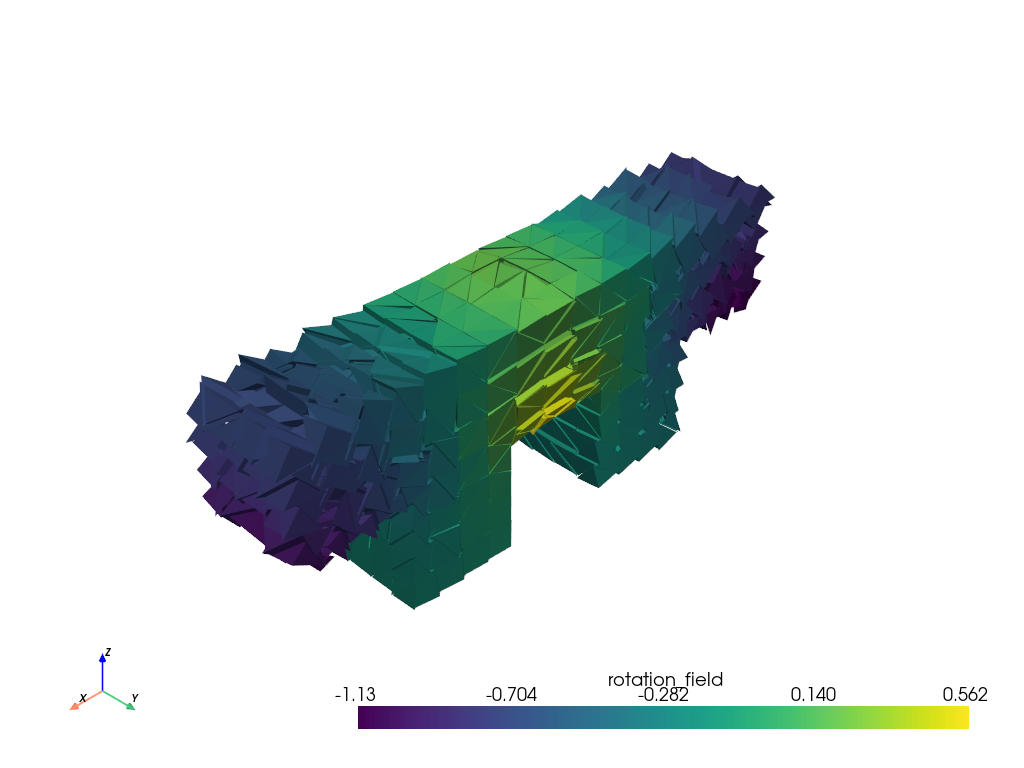

In [3]:

def calculate_initial_rotation_field(tet, MAX_OVERHANG, ROTATION_MULTIPLIER, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION):
    '''
    Calculate the initial rotation field for each cell in the tetrahedral mesh to make overhangs less than MAX_OVERHANG.
    The direction of rotation ensures the part is printable.
    '''

    # create initial rotation field rotating faces to be in safe printing angle
    initial_rotation_field = np.full((tet.number_of_cells), np.nan)
    initial_rotation_field = np.abs(np.deg2rad(90+MAX_OVERHANG) - tet.cell_data['overhang_angle'])

    path_length_to_base_gradient = calculate_path_length_to_base_gradient(tet, MAX_OVERHANG, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO)

    # if path_length_to_base_gradient is different to the cell's overhang direction, it needs to be rotated an additional amount (its overhang angle) to make it go the right way
    # Put behind a flag because it is normally not needed, and buggy/finnicky
    # Can try enable it for models with very steep overhangs (>90 degrees) (not common)
    if STEEP_OVERHANG_COMPENSATION:
        initial_rotation_field[tet.cell_data["in_air"]] += 2 * (np.deg2rad(180) - tet.cell_data['overhang_angle'][tet.cell_data["in_air"]])

    # # Apply the path_length_to_base_gradient (optimal overhang direction) to the initial rotation field
    initial_rotation_field *= path_length_to_base_gradient

    # apply rotation multiplier
    initial_rotation_field = np.clip(initial_rotation_field*ROTATION_MULTIPLIER, -np.deg2rad(360), np.deg2rad(360))

    # clip to max rotation
    initial_rotation_field = np.clip(initial_rotation_field, MAX_NEG_ROTATION, MAX_POS_ROTATION)

    tet.cell_data["initial_rotation_field"] = initial_rotation_field

    return initial_rotation_field

from scipy.sparse import lil_matrix

def calculate_rotation_matrices(tet, rotation_field):
    '''
    Calculate the rotation matrices for each cell in the tetrahedral mesh given the scalar
    rotation field that gives a rotation for each cell. Cells are rotated around the axis
    perpendicular to the radial direction and the z-axis.
    '''

    # create rotation matrix from theta around axis
    tangential_vectors = np.cross( np.array([0, 0, 1]), tet.cell_data["cell_center"][:, :2])
    # normalize
    tangential_vectors /= np.linalg.norm(tangential_vectors, axis=1)[:, None]
    # replace nan with [1,0,0]
    tangential_vectors[np.isnan(tangential_vectors).any(axis=1)] = [1, 0, 0]

    rotation_matrices = R.from_rotvec(rotation_field[:, None] * tangential_vectors).as_matrix()

    return rotation_matrices

def calculate_unique_vertices_rotated(tet, rotation_field):
    '''
    Calculate the vertices of a tetrahedral mesh after rotating each cell by the rotation field.
    Vertices are unique: they are not shared between cells.
    '''

    rotation_matrices = calculate_rotation_matrices(tet, rotation_field)

    # rotate each face by the rotation field around its center
    unique_vertices = np.zeros((tet.number_of_cells, 4, 3))
    for cell_index, cell in enumerate(tet.field_data["cells"]):
        unique_vertices[cell_index] = tet.field_data["cell_vertices"][cell]

    cell_centers = tet.cell_data["cell_center"]

    unique_vertices_rotated = cell_centers.reshape(-1, 1, 3, 1) + rotation_matrices.reshape(-1, 1, 3, 3) @ (unique_vertices.reshape(-1, 4, 3, 1) - cell_centers.reshape(-1, 1, 3, 1))
    # unique_vertices_rotated = rotation_matrices.reshape(-1, 1, 3, 3) @ unique_vertices.reshape(-1, 4, 3, 1)

    return unique_vertices_rotated

def apply_rotation_field_unique_vertices(tet, rotation_field):
    '''
    Apply the rotation field to the tetrahedral mesh and return a new tetrahedral mesh.
    Vertices are unique: they are not shared between cells.
    '''

    unique_vertices_rotated = calculate_unique_vertices_rotated(tet, rotation_field)

    unique_cells = np.zeros((tet.number_of_cells, 5), dtype=int)
    unique_cells[:, 0] = 4
    unique_cells[:, 1:] = np.arange(tet.number_of_cells*4).reshape(-1, 4)

    new_tet = pv.UnstructuredGrid(unique_cells.flatten(), np.full(tet.number_of_cells, pv.CellType.TETRA), unique_vertices_rotated.reshape(-1, 3))

    return new_tet

def apply_rotation_field(tet, rotation_field):
    '''
    Apply the rotation field to the tetrahedral mesh and return a new tetrahedral mesh.
    Vertices are shared between cells, so the surface is closed and smooth.
    '''

    new_vertices = np.zeros((tet.number_of_points, 3))
    vertices_count = np.zeros((tet.number_of_points))
    for cell in tet.field_data["cells"]:
        vertices_count[cell] += 1

    unique_vertices_rotated = calculate_unique_vertices_rotated(tet, rotation_field)

    for cell_index, vertices in enumerate(unique_vertices_rotated):
        for i, vertex in enumerate(vertices):
            new_vertices[tet.field_data["cells"][cell_index, i]] += vertex.T[0] / vertices_count[tet.field_data["cells"][cell_index][i]]

    new_tet = pv.UnstructuredGrid(tet.cells, np.full(tet.number_of_cells, pv.CellType.TETRA), new_vertices)

    return new_tet


def optimize_rotations(tet, NEIGHBOUR_LOSS_WEIGHT, MAX_OVERHANG, ROTATION_MULTIPLIER, ITERATIONS, SAVE_GIF, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION):
    '''
    Optimize the rotation field for each cell in the tetrahedral mesh to make overhangs less
    than MAX_OVERHANG while keeping the rotation field smooth.
    '''

    imgs = []
    plotter = pv.Plotter(off_screen=True)
    if SAVE_GIF:
        plotter.open_gif(f'gifs/{model_name}_optimize_rotations.gif')

    initial_rotation_field = calculate_initial_rotation_field(tet, MAX_OVERHANG, ROTATION_MULTIPLIER, STEEP_OVERHANG_COMPENSATION, INITIAL_ROTATION_FIELD_SMOOTHING, SET_INITIAL_ROTATION_TO_ZERO, MAX_POS_ROTATION, MAX_NEG_ROTATION)
    num_cells_with_initial_rotation = np.sum(~np.isnan(initial_rotation_field))

    def save_gif(rotation_field):
        new_tet = apply_rotation_field_unique_vertices(tet, rotation_field)
        new_tet.cell_data["rotation_field"] = rotation_field
        mesh_actor = plotter.add_mesh(new_tet,  clim=[-np.pi/4, np.pi/4], scalars="rotation_field", lighting=False)
        plotter.write_frame()
        plotter.remove_actor(mesh_actor)

    def objective_function(rotation_field):
        '''
        Objective function to minimize the neighbour losses and initial rotation losses.
        '''
        if SAVE_GIF:
            save_gif(rotation_field)

        # Compute neighbour losses using vectorized operations
        cell_face_neighbours = tet.field_data["cell_face_neighbours"]
        neighbour_differences = rotation_field[cell_face_neighbours[:, 0]] - rotation_field[cell_face_neighbours[:, 1]]
        neighbour_losses = NEIGHBOUR_LOSS_WEIGHT * neighbour_differences**2

        # Compute the initial rotation losses
        overhanging_mask = tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)
        valid_cell_indices = np.where(~np.isnan(initial_rotation_field))[0]#np.where(overhanging_mask)[0]
        initial_rotation_losses = (rotation_field[valid_cell_indices] - initial_rotation_field[valid_cell_indices])**2

        # Return the concatenated losses
        return np.concatenate((neighbour_losses, initial_rotation_losses))


    def objective_jacobian(rotation_field):
        start_time = time.time()
        # Initialize the sparse matrix with LIL format for efficient row-wise operations
        cell_face_neighbours = tet.field_data["cell_face_neighbours"]
        jac = lil_matrix((len(cell_face_neighbours) + num_cells_with_initial_rotation, tet.number_of_cells), dtype=np.float32)

        # Vectorized computation for neighbour loss derivatives
        cell_1 = cell_face_neighbours[:, 0]
        cell_2 = cell_face_neighbours[:, 1]

        # Compute the differences
        differences = rotation_field[cell_1] - rotation_field[cell_2]

        # Fill in the Jacobian for the first derivative of the neighbour loss function
        jac[range(len(cell_face_neighbours)), cell_1] = 2 * NEIGHBOUR_LOSS_WEIGHT * differences
        jac[range(len(cell_face_neighbours)), cell_2] = -2 * NEIGHBOUR_LOSS_WEIGHT * differences

        # Vectorized computation for initial rotation loss derivatives
        overhanging_mask = tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)
        valid_cell_indices = np.where(~np.isnan(initial_rotation_field))[0]#np.where(overhanging_mask)[0]

        # Fill in the Jacobian for the first derivative of the initial rotation loss function
        jac[len(cell_face_neighbours) + np.arange(len(valid_cell_indices)), valid_cell_indices] = \
            2 * (rotation_field[valid_cell_indices] - initial_rotation_field[valid_cell_indices])

        # print("Jacobian time:", time.time() - start_time)
        # Convert the LIL matrix to CSR format for efficient computations in further steps
        return jac.tocsr()

    def jac_sparsity():
        cell_face_neighbours = tet.field_data["cell_face_neighbours"]
        sparsity = lil_matrix((len(cell_face_neighbours) + num_cells_with_initial_rotation, tet.number_of_cells), dtype=np.int8)

        for i, (cell_1, cell_2) in enumerate(cell_face_neighbours):
            sparsity[i, cell_1] = 1
            sparsity[i, cell_2] = 1

        valid_cell_indices = np.where(~np.isnan(initial_rotation_field))[0]#np.where(overhanging_mask)[0]
        i = 0
        for cell_index, initial_rotation in enumerate(initial_rotation_field):
            if cell_index in valid_cell_indices:
                sparsity[len(cell_face_neighbours) + i, cell_index] = 1
                i += 1

        return sparsity.tocsr()

    smoothed_rotation_field = np.zeros((tet.number_of_cells))

    # Optimization process to smooth the initial rotation field
    result = least_squares(objective_function,
                    smoothed_rotation_field,
                    jac=objective_jacobian,
                    max_nfev=ITERATIONS,
                    jac_sparsity=jac_sparsity(),
                    verbose=2,
                    method='trf',
                    ftol=1e-6,
                    )

    # render array of numpy images (imgs) into gif
    if SAVE_GIF:
        plotter.close()

    return result.x

NEIGHBOUR_LOSS_WEIGHT = 20 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 30          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 2   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = False # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
MAX_POS_ROTATION = np.deg2rad(3600) # normally set to 360 unless you get collisions
MAX_NEG_ROTATION = np.deg2rad(-3600) # normally set to 360 unless you get collisions
ITERATIONS = 100
SAVE_GIF = True
STEEP_OVERHANG_COMPENSATION = True

rotation_field = optimize_rotations(
    undeformed_tet,
    NEIGHBOUR_LOSS_WEIGHT,
    MAX_OVERHANG,
    ROTATION_MULTIPLIER,
    ITERATIONS,
    SAVE_GIF,
    STEEP_OVERHANG_COMPENSATION,
    INITIAL_ROTATION_FIELD_SMOOTHING,
    SET_INITIAL_ROTATION_TO_ZERO,
    MAX_POS_ROTATION,
    MAX_NEG_ROTATION
)
# rotation_field = calculate_initial_rotation_field(tet, MAX_OVERHANG, ROTATION_MULTIPLIER)
undeformed_tet_with_rotated_tetrahedrons = apply_rotation_field_unique_vertices(undeformed_tet, rotation_field)
undeformed_tet_with_rotated_tetrahedrons.cell_data["rotation_field"] = rotation_field
# new_tet.extract_cells(np.where(rotation_field != 0)[0]).plot()
undeformed_tet_with_rotated_tetrahedrons.plot(scalars="rotation_field")

default
```
NEIGHBOUR_LOSS_WEIGHT = 20 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 30          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 2   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = False # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
```

benchy upsidedown tilted
scale: 1.5
Iteration 1:
```
NEIGHBOUR_LOSS_WEIGHT = 100 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 5          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 1   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

Iteration 2:
```
NEIGHBOUR_LOSS_WEIGHT = 50 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 5          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 1   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

Iteration 3,4,5:
```
NEIGHBOUR_LOSS_WEIGHT = 50 # the larger the weight, the more the rotation field will be smoothed
MAX_OVERHANG = 50          # the maximum overhang angle in degrees
ROTATION_MULTIPLIER = 3   # the larger the multiplier, the more the rotation field will be rotated
SET_INITIAL_ROTATION_TO_ZERO = True # reduces influence of initial rotation field on non-overhanging tetrahedrons. good when initial rotation field is noisy
INITIAL_ROTATION_FIELD_SMOOTHING = 30
```

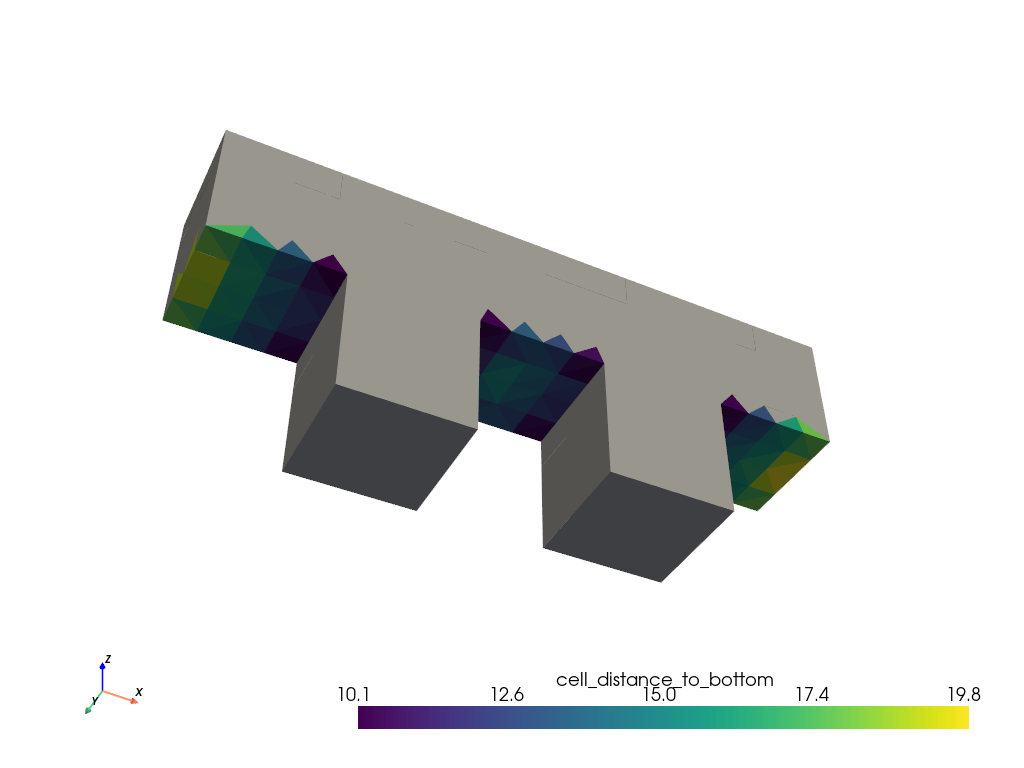

In [4]:
# view the initial rotation field we are trying to optimize towards
# tet.extract_cells(tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)).plot(scalars="initial_rotation_field")
# tet.cell_data['overhang_angle'] > np.deg2rad(90 + MAX_OVERHANG)
# undeformed_tet.plot(scalars="initial_rotation_field")
# undeformed_tet.plot(scalars="in_air")
undeformed_tet.plot(scalars="cell_distance_to_bottom", cpos=[-0.5, -1, -1])
# undeformed_tet.plot(scalars="overhang_angle")
# undeformed_tet.plot(scalars="path_length_to_base_gradient")
# undeformed_tet.plot(scalars=new_tet1.cell_data['rotation_field'])

def show_path_to_base(tet, cell_index, plotter=pv.Plotter()):
    path_to_bottom = tet.cell_data['path_to_bottom'][cell_index]
    first_negative_index = np.where(path_to_bottom == -1)[0][0]
    path_to_bottom = path_to_bottom[:first_negative_index]
    print(path_to_bottom)

    for i in range(len(path_to_bottom)-1):
        path_to_base = pv.Line(tet.cell_data["cell_center"][path_to_bottom[i]], tet.cell_data["cell_center"][path_to_bottom[i+1]])
        plotter.add_mesh(path_to_base, color="red")

    plotter.add_mesh(tet, opacity=0.2)
    plotter.show()

# show_path_to_base(tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][7])

def show_path_to_base_gradient_calculation(tet, cell_indices):
    plotter = pv.Plotter()
    scalar = np.full(tet.number_of_cells, 0.0)

    for cell_index in cell_indices:
        local_cells = cell_neighbour_dict["edge"][cell_index]
        local_cells = np.hstack((local_cells, cell_index))
        local_cells_with_path_lengths = [x for x in local_cells if not np.isnan(tet.cell_data['cell_distance_to_bottom'][x])]
        path_lengths = tet.cell_data['cell_distance_to_bottom'][local_cells_with_path_lengths]

        cell_centers = tet.cell_data["cell_center"][local_cells_with_path_lengths]
        cell_centers_z_is_path_length = cell_centers.copy()
        cell_centers_z_is_path_length[:, 2] = path_lengths - np.min(path_lengths) + np.min(cell_centers[:, 2])
        points = pv.PolyData(cell_centers_z_is_path_length)
        glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.1))

        if len(cell_centers_z_is_path_length) < 3:
            continue

        p, n = planeFit(cell_centers_z_is_path_length.T)
        plane = pv.Plane(center=p, direction=n, i_size=4, j_size=4)
        normal_arrow = pv.Arrow(start=p, direction=n, scale=1.5)

        # reflect arrow across xy plane
        reflected_n = -n - 2 * (np.dot(-n, up_vector)) * up_vector

        # extract radial component
        cell_center_direction_normalized = tet.cell_data["cell_center"][cell_index, :2] / np.linalg.norm(tet.cell_data["cell_center"][cell_index, :2])
        gradient_in_radial_direction = np.dot(cell_center_direction_normalized, reflected_n[:2]) * cell_center_direction_normalized
        nozzle_arrow = pv.Arrow(start=tet.cell_data["cell_center"][cell_index], direction=np.hstack((gradient_in_radial_direction, reflected_n[2])), scale=1)


        # plotter.add_mesh(glyph, color="blue", opacity=0.5, )
        # plotter.add_mesh(plane, color="green", opacity=0.2)
        # plotter.add_mesh(normal_arrow, color="orange")
        plotter.add_mesh(nozzle_arrow, color="red")
    scalar[local_cells_with_path_lengths] = 0.5
    scalar[cell_index] = 1
    plotter.add_mesh(tet, opacity=0.2, scalars=scalar, cmap="binary")
    plotter.show()

# show_path_to_base_gradient_calculation(undeformed_tet, [np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][1]])
# show_path_to_base_gradient_calculation(undeformed_tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > np.deg2rad(90 + MAX_OVERHANG)))[0])

def show_dijkstras(tet, cell_index):
    plotter = pv.Plotter()#window_size=[3840, 2160])
    lines = []
    for neighbour in tet.field_data["cell_face_neighbours"]:
        lines += [tet.cell_data["cell_center"][neighbour[0]], tet.cell_data["cell_center"][neighbour[1]]]
    mesh = pv.line_segments_from_points(lines)
    plotter.add_mesh(mesh, color="grey", opacity=0.4)

    points = pv.PolyData(tet.cell_data["cell_center"])
    glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.1))
    plotter.add_mesh(glyph, color="red", opacity=0.2)

    if cell_index is None:
        plotter.show()
        return

    plotter.camera_position = "xz"

    # run dijkstra's algorithm and visualize
    plotter.open_gif(f'gifs/{model_name}_dijkstra.gif')
    distances, paths = nx.single_source_dijkstra(cell_neighbour_graph, cell_index)
    dijkstra_actors = []
    for i in np.arange(0, tet.cell_data['cell_distance_to_bottom'][cell_index], 0.2):
        nodes_in_range = [node for node, distance in distances.items() if distance < i]
        if len(nodes_in_range) == 0:
            continue
        if set(nodes_in_range) & set(bottom_cells):
            break
        points = pv.PolyData(tet.cell_data["cell_center"][nodes_in_range])
        glyph = points.glyph(geom=pv.Sphere(theta_resolution=8, phi_resolution=8, radius=0.2))
        actor = plotter.add_mesh(glyph, color="blue", opacity=0.4)
        dijkstra_actors.append(actor)
        plotter.write_frame()


    path_to_bottom = tet.cell_data['path_to_bottom'][cell_index]
    first_negative_index = np.where(path_to_bottom == -1)[0][0]
    path_to_bottom = path_to_bottom[:first_negative_index]
    print(path_to_bottom)

    for i in range(len(path_to_bottom)-1):
        path_to_base = pv.Line(tet.cell_data["cell_center"][path_to_bottom[i]], tet.cell_data["cell_center"][path_to_bottom[i+1]])
        plotter.add_mesh(path_to_base, color="blue", line_width=5)

    for actor in dijkstra_actors:
        plotter.remove_actor(actor)

    plotter.write_frame()

    plotter.show()
    plotter.close()


# show_dijkstras(undeformed_tet, np.where(tet.cell_data['has_face'].astype(bool) & (tet.cell_data["overhang_angle"] > 3))[0][1])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8031e+04                                    3.20e+03    
       1              4         2.5646e+04      2.38e+03       6.07e+00       2.89e+03    
       2              5         2.2398e+04      3.25e+03       3.65e+00       2.61e+03    
       3              6         1.9306e+04      3.09e+03       6.83e+00       2.23e+03    
       4              7         1.4902e+04      4.40e+03       5.45e+00       1.76e+03    
       5              8         1.1670e+04      3.23e+03       5.29e+00       1.42e+03    
       6              9         9.0340e+03      2.64e+03       5.28e+00       1.10e+03    
       7             10         7.1177e+03      1.92e+03       5.73e+00       8.45e+02    
       8             11         5.6462e+03      1.47e+03       5.99e+00       6.53e+02    
       9             12         4.4996e+03      1.15e+03       5.91e+00       4.97e+02    

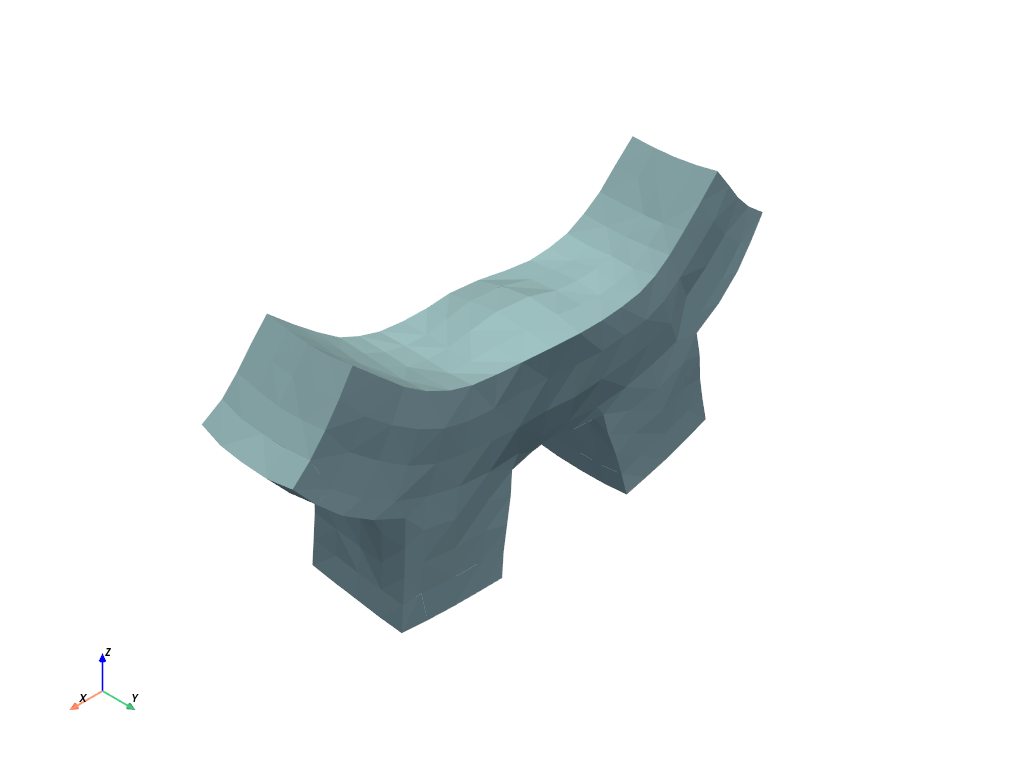

In [5]:
N = np.eye(4) - 1/4 * np.ones((4, 4)) # the N matrix centers the vertices of a tetrahedron around the origin

save_gif_i = 0

def calculate_deformation(tet, rotation_field, ITERATIONS, SAVE_GIF):
    '''
    Try to find the optimal deformation of the tetrahedral mesh to make cells have the same rotation as
    the given rotation field.

    Our parameters are the vertices of the deformed mesh.
    '''

    new_vertices = tet.points.copy()

    params = new_vertices.flatten()

    rotation_matrices = calculate_rotation_matrices(tet, rotation_field)

    # Extract old vertices for all cells
    old_vertices = tet.field_data["cell_vertices"][tet.field_data["cells"]]
    # Apply the transformation for all cells
    old_vertices_transformed = np.einsum('ijk,ikl->ijl', rotation_matrices, (N @ old_vertices).transpose(0, 2, 1))

    plotter = pv.Plotter(off_screen=True)

    if SAVE_GIF:
        plotter.open_gif(f'gifs/{model_name}_calculate_deformation.gif')

    def save_gif(new_vertices):
        global save_gif_i
        save_gif_i += 1

        if save_gif_i % 10 != 0:
            return

        new_tet = pv.UnstructuredGrid(tet.cells, np.full(tet.number_of_cells, pv.CellType.TETRA), new_vertices)
        mesh_actor = plotter.add_mesh(new_tet)
        plotter.write_frame()
        plotter.remove_actor(mesh_actor)


    def objective_function(params):
        start_time = time.time()

        new_vertices = params[:tet.number_of_points * 3].reshape(-1, 3)

        if SAVE_GIF:
            save_gif(new_vertices)

        # Apply transformation for the new vertices
        new_vertices_transformed = (N @ new_vertices[tet.field_data["cells"]]).transpose(0, 2, 1)

        # Calculate position compatibility loss using vectorized operations
        position_losses = np.linalg.norm(new_vertices_transformed - old_vertices_transformed, axis=(1, 2))**2

        # print(f"Objective function took {time.time() - start_time} seconds")
        return position_losses

    def objective_jacobian(params):
        start_time = time.time()

        # Initialize Jacobian matrix
        J = lil_matrix((tet.number_of_cells, len(params)), dtype=np.float32)

        # Extract parameters
        new_vertices = params[:tet.number_of_points * 3].reshape(-1, 3)

        # Extract old vertices for all cells
        old_vertices = tet.field_data["cell_vertices"][tet.field_data["cells"]]

        # Apply the transformation for old and new vertices
        new_vertices_transformed = (N @ new_vertices[tet.field_data["cells"]]).transpose(0, 2, 1)

        # Compute the difference between transformed new and old vertices
        diff = new_vertices_transformed - old_vertices_transformed  # shape: (num_cells, 3, num_vertices_per_cell)

        # Reshape diff for easier broadcasting
        diff = diff.transpose(0, 2, 1)  # shape: (num_cells, num_vertices_per_cell, 3)

        # Now, for each cell, update the corresponding rows in the Jacobian
        cell_indices = np.repeat(np.arange(tet.number_of_cells), len(tet.field_data["cells"][0]))  # Cell indices repeated per vertex
        vertex_indices = np.ravel(tet.field_data["cells"])  # Flatten the cell-to-vertex mapping

        # For each component x, y, z in the vertex, update the Jacobian
        for dim in range(3):
            J[cell_indices, vertex_indices * 3 + dim] = 2 * diff[:, :, dim].ravel()

        # print(f"Objective jacobian took {time.time() - start_time} seconds")
        return J.tocsr()

    def jac_sparsity():
        sparsity = lil_matrix((tet.number_of_cells, len(params)), dtype=np.int8)

        cell_indices = np.repeat(np.arange(tet.number_of_cells), len(tet.field_data["cells"][0]))
        vertex_indices = np.ravel(tet.field_data["cells"])

        for dim in range(3):
            sparsity[cell_indices, vertex_indices * 3 + dim] = 1

        return sparsity.tocsr()

    result = least_squares(objective_function,
                    params,
                    max_nfev=ITERATIONS,
                    verbose=2,
                    jac=objective_jacobian,
                    jac_sparsity=jac_sparsity(),
                    method='trf',
                    x_scale='jac',
                    )

    plotter.close()

    return result.x[:tet.number_of_points*3].reshape(-1, 3)

ITERATIONS = 1000
SAVE_GIF = True
new_vertices = calculate_deformation(undeformed_tet, rotation_field, ITERATIONS, SAVE_GIF)
deformed_tet = pv.UnstructuredGrid(undeformed_tet.cells, np.full(undeformed_tet.number_of_cells, pv.CellType.TETRA), new_vertices)
deformed_tet.plot()

for key in undeformed_tet.field_data.keys():
    deformed_tet.field_data[key] = undeformed_tet.field_data[key]
for key in undeformed_tet.cell_data.keys():
    deformed_tet.cell_data[key] = undeformed_tet.cell_data[key]
deformed_tet = update_tet_attributes(deformed_tet)

Run below to do another iteration

In [6]:
undeformed_tet = deformed_tet.copy()

Run below when finished deforming to save mesh as STL

In [7]:
# make origin center bottom of bounding box
x_min, x_max, y_min, y_max, z_min, z_max = deformed_tet.bounds
offsets_applied = np.array([(x_min + x_max) / 2, (y_min + y_max) / 2, z_min])
deformed_tet.points -= offsets_applied

deformed_tet.extract_surface().save(f'output_models/{model_name}_deformed_tet.stl')

In [8]:

# save to pickle
with open(f'pickle_files/deformed_{model_name}.pkl', 'wb') as f:
    pickle.dump(deformed_tet, f)

# Now, go and slice the stl file in Cura!

Settings:
- Make the printer origin at the center of the buildplate
- Dont use any pre/post scripts, z hop, etc. The config I use is provided in the github repo
- Autoplace the model at the center by clicking "Arrange All Models"

In [9]:

deformed_tet = pickle.load(open(f'pickle_files/deformed_{model_name}.pkl', 'rb'))

In [10]:
def tetrahedron_volume(p1, p2, p3, p4):
    '''
    Calculate the volume of the tetrahedron formed by four points
    '''

    mat = np.vstack([p2 - p1, p3 - p1, p4 - p1])
    return np.abs(np.linalg.det(mat)) / 6

def calc_barycentric_coordinates(tet_a, tet_b, tet_c, tet_d, point):
    '''
    Calculate the barycentric coordinates of a point in a tetrahedron. This is used to interpolate
    parameters from the vertices of the tetrahedron to a point within the tetrhedron.
    '''

    total_volume = tetrahedron_volume(tet_a, tet_b, tet_c, tet_d)

    if total_volume == 0:
        raise ValueError("The points do not form a valid tetrahedron (zero volume).")

    # Calculate the sub-volumes for each face
    vol_a = tetrahedron_volume(point, tet_b, tet_c, tet_d)
    vol_b = tetrahedron_volume(point, tet_a, tet_c, tet_d)
    vol_c = tetrahedron_volume(point, tet_a, tet_b, tet_d)
    vol_d = tetrahedron_volume(point, tet_a, tet_b, tet_c)

    # Calculate barycentric coordinates as the ratio of sub-volumes to total volume
    lambda_a = vol_a / total_volume
    lambda_b = vol_b / total_volume
    lambda_c = vol_c / total_volume
    lambda_d = vol_d / total_volume

    # The barycentric coordinates should sum to 1
    return np.array([lambda_a, lambda_b, lambda_c, lambda_d])

def project_point_onto_plane(plane_x_axis, plane_y_axis, point):
    projected_x = np.sum(plane_x_axis * point, axis=1)
    projected_y = np.sum(plane_y_axis * point, axis=1)

    return np.array([projected_x, projected_y]).T

In [18]:
deformed_tet, _, _ = calculate_tet_attributes(deformed_tet)

In [12]:
from pygcode import Line
import time

SEG_SIZE = 0.6 # mm
MAX_ROTATION = 30 # degrees
MIN_ROTATION = -130 # degrees
NOZZLE_OFFSET = 42 # mm actuallt 41.5

# find how each vertex in tet has been transformed
vertex_transformations = deformed_tet.points - input_tet.points

# calculate tangential vectors (axis of rotation) for each cell
tangential_vectors = np.cross( np.array([0, 0, 1]), input_tet.cell_data["cell_center"][:, :2])
# normalize
tangential_vectors /= np.linalg.norm(tangential_vectors, axis=1)[:, None]
# replace nan with [1,0,0]
tangential_vectors[np.isnan(tangential_vectors).any(axis=1)] = [1, 0, 0]

# calculate rotation for each vertex and cell
num_cells_per_vertex = np.zeros((input_tet.number_of_points))
for cell_index, cell in enumerate(input_tet.field_data["cells"]):
    num_cells_per_vertex[cell] += 1
vertex_rotations = np.zeros((deformed_tet.number_of_points))
cell_rotations = np.zeros((deformed_tet.number_of_cells))
for cell_index, cell in enumerate(deformed_tet.field_data["cells"]):
    new_vertices = deformed_tet.field_data["cell_vertices"][cell]
    new_cell_center = deformed_tet.cell_data["cell_center"][cell_index]
    old_vertices = input_tet.field_data["cell_vertices"][cell]
    old_cell_center = input_tet.cell_data["cell_center"][cell_index]

    # center points
    new_vertices -= new_cell_center
    old_vertices -= old_cell_center

    # project on to radial plane
    plane_x_vector = old_cell_center[:2] / np.linalg.norm(old_cell_center[:2])
    plane_x_vector = np.array([plane_x_vector[0], plane_x_vector[1], 0])
    plane_y_vector = np.array([0,0,1])

    new_vertices_projected = project_point_onto_plane(plane_x_vector, plane_y_vector, new_vertices)
    old_vertices_projected = project_point_onto_plane(plane_x_vector, plane_y_vector, old_vertices)

    # find rotation between the two sets of points using the kabsch algorithm
    covariance_matrix = np.dot(new_vertices_projected.T, old_vertices_projected)
    U, _, Vt = np.linalg.svd(covariance_matrix)
    rotation_matrix = np.dot(U, Vt)

    # get rotation angle from matrix 2x2
    rotation = -np.arccos(min(max(rotation_matrix[0, 0], -1), 1))
    if rotation_matrix[1, 0] < 0:
        rotation = -rotation

    rotation = max(min(rotation, np.deg2rad(MAX_ROTATION)), np.deg2rad(MIN_ROTATION))

    cell_rotations[cell_index] = rotation

    for vertex_index in cell:
        vertex_rotations[vertex_index] += rotation / num_cells_per_vertex[vertex_index]

# calculate z squish scale for each cell (ratio of z length after rotation to z length before rotation)
tet_rotation_matrices = calculate_rotation_matrices(input_tet, cell_rotations)
z_squish_scales = np.full((deformed_tet.number_of_cells), np.nan)
for cell_index, cell in enumerate(deformed_tet.field_data["cells"]):
    warped_vertices = deformed_tet.field_data["cell_vertices"][cell]
    unwarped_vertices = input_tet.field_data["cell_vertices"][cell]

    # rotate new vertices to align with old vertices
    unwarped_vertices_rotated = (tet_rotation_matrices[cell_index].reshape(1, 3, 3) @ unwarped_vertices.reshape(4, 3, 1)).reshape(4, 3)

    # calculate z squish scale
    # z_squish_scales[cell_index] = (unwarped_vertices_rotated[:, 2].max() - unwarped_vertices_rotated[:, 2].min()) / (warped_vertices[:, 2].max() - warped_vertices[:, 2].min())
    z_squish_scales[cell_index] = tetrahedron_volume(*unwarped_vertices) / tetrahedron_volume(*warped_vertices)
    # z_squish_scales[cell_index] = min(z_squish_scales[cell_index], 5) # cap z squish scale


# read gcode
pos = np.array([0., 0., 20.])
feed = 5000
gcode_points = []
with open(f'input_gcode/{model_name}_deformed_tet.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text)

        if not line.block.gcodes:
            continue

        for gcode in sorted(line.block.gcodes):
            if gcode.word == "G01" or gcode.word == "G00":
                prev_pos = pos.copy()

                if gcode.X is not None:
                    pos[0] = gcode.X
                if gcode.Y is not None:
                    pos[1] = gcode.Y
                if gcode.Z is not None:
                    pos[2] = gcode.Z

                inv_time_feed = None
                # extract feed
                for word in line.block.words:
                    if word.letter == "F":
                        feed = word.value

                # extract extrusion
                extrusion = None
                for param in line.block.modal_params:
                    if param.letter == "E":
                        extrusion = param.value

                # segment moves
                # makes G1 (feed moves) less jittery
                delta_pos = pos - prev_pos
                distance = np.linalg.norm(delta_pos)
                if distance > 0:
                    num_segments = -(-distance // SEG_SIZE) # hacky round up
                    seg_distance = distance/num_segments

                    # calculate inverse time feed
                    time_to_complete_move = (1/feed) * seg_distance # min/mm * mm = min
                    if time_to_complete_move == 0:
                        inv_time_feed = None
                    else:
                        inv_time_feed = 1/time_to_complete_move # 1/min

                    for i in range(int(num_segments)):
                        gcode_points.append({
                            "position": (prev_pos + delta_pos * (i+1) / num_segments),
                            "command": gcode.word,
                            "extrusion": extrusion/num_segments if extrusion is not None else None,
                            "inv_time_feed": inv_time_feed,
                            "move_length": seg_distance,
                            "start_position": prev_pos,
                            "end_position": pos,
                            "unsegmented_move_length": distance,
                            "after_retract": False,
                            "feed": feed
                        })
                else:
                    # calculate inverse time feed
                    time_to_complete_move = (1/feed) * distance # min/mm * mm = min
                    if time_to_complete_move == 0:
                        inv_time_feed = None
                    else:
                        inv_time_feed = 1/time_to_complete_move # 1/min

                    gcode_points.append({
                        "position": pos.copy(),
                        "command": gcode.word,
                        "extrusion": extrusion,
                        "inv_time_feed": inv_time_feed,
                        "move_length": distance,
                        "unsegmented_move_length": distance,
                        "after_retract": False,
                        "feed": feed
                    })

                # # add G0 in same spot after retraction (so we can use it for zhop later)
                # if gcode.word == "G01" and extrusion is not None and extrusion < 0:
                #     gcode_points.append({
                #         "position": pos.copy(),
                #         "command": "G00",
                #         "extrusion": None,
                #         "inv_time_feed": None,
                #         "move_length": 0,
                #         "after_retract": True
                #     })

# calculate containging cell for each gcode point
gcode_points_containing_cells = deformed_tet.find_containing_cell([point["position"] for point in gcode_points])

# for cells with no containing cell, find the closest cell
gcode_points_closest_cells = deformed_tet.find_closest_cell([point["position"] for point in gcode_points])
# gcode_points_containing_cells[gcode_points_containing_cells == -1] = gcode_points_closest_cells[gcode_points_containing_cells == -1]

# transform gcode points to original mesh's shape
new_gcode_points = []
prev_new_position = None
travelling_over_air = False
travelling = False
prev_position = None
prev_rotation = 0
prev_travelling = False
prev_command = "G00"
ROTATION_AVERAGING_ALPHA = 0.2 # exponential moving average alpha for rotation
RETRACTION_LENGTH = 1.0
ROTATION_MAX_DELTA = np.deg2rad(1)
MAX_EXTRUSION_MULTIPLIER = 10
lost_vertices = []
highest_printed_point = 0
for cell_index, (gcode_point, containing_cell_index) in enumerate(zip(gcode_points, gcode_points_containing_cells)):
    position = gcode_point["position"]
    command = gcode_point["command"]
    inv_time_feed = gcode_point["inv_time_feed"]
    extrusion = gcode_point["extrusion"]

    def barycentric_interpolate_to_get_new_position_and_rotation(position, containing_cell_index, command, cell_index):
        if command == "G00" and containing_cell_index == -1: # Strict on travel moves being inside a tet
            return None, None
        if command == "G01" and containing_cell_index == -1: # Slightly more relaxed on printing moves
            containing_cell_index = gcode_points_closest_cells[cell_index]

        # get barycentric coordinates of pos in containing cell
        vertiex_indices = deformed_tet.field_data["cells"][containing_cell_index]
        cell_vertices = deformed_tet.field_data["cell_vertices"][vertiex_indices]
        barycentric_coordinates = calc_barycentric_coordinates(cell_vertices[0], cell_vertices[1], cell_vertices[2], cell_vertices[3], position)

        if np.sum(barycentric_coordinates) > 1.01:
            return None, None

        # calculate the new position of the point using the barycentric coordinates to weigh the vertex transformations
        # multiply barycentric coordinates row-wise with vertex transformations
        transformation = vertex_transformations[vertiex_indices] * barycentric_coordinates[:, None]

        # sum columns
        transformation = np.sum(transformation, axis=0)
        # apply to pos
        new_position = position - transformation

        # do the same for rotation
        rotation = np.sum(vertex_rotations[vertiex_indices] * barycentric_coordinates)

        return new_position, rotation

    dont_smooth_rotation = False
    new_position, rotation = barycentric_interpolate_to_get_new_position_and_rotation(position, containing_cell_index, command, cell_index)
    if new_position is None:
        if command == "G01":
            lost_vertices.append(position)
            continue
        elif command == "G00" and not travelling_over_air and prev_new_position is not None:
            new_position = np.array([prev_new_position[0], prev_new_position[1], highest_printed_point]) # z hop over gap
            rotation = max(min(prev_rotation, np.deg2rad(45)), np.deg2rad(-45)) # set rotation to a max of 45 because if rotation is very large, the extruder can "hang below" the nozzle and hit the part
            dont_smooth_rotation = True # force rotation immediately
            travelling_over_air = True
        elif travelling_over_air:
            continue
        else:
            continue
    else:
        if travelling_over_air:
            new_position[2] = highest_printed_point # finish z hop over gap
            rotation = max(min(rotation, np.deg2rad(45)), np.deg2rad(-45)) # set rotation to 0 because if rotation is very large, the extruder can "hang below" the nozzle and hit the part
            dont_smooth_rotation = True # force rotation immediately
        travelling_over_air = False

    extrusion_multiplier = 1
    if extrusion is not None and extrusion != RETRACTION_LENGTH and extrusion != -RETRACTION_LENGTH:

        # scale extrusion by z_squish_scale
        extrusion_multiplier = extrusion_multiplier * z_squish_scales[containing_cell_index]
        extrusion = extrusion * min(extrusion_multiplier, MAX_EXTRUSION_MULTIPLIER)
    elif extrusion == -RETRACTION_LENGTH:
        travelling = True
    elif extrusion == RETRACTION_LENGTH:
        travelling = False
    if prev_rotation is not None and not dont_smooth_rotation:
        rotation = ROTATION_AVERAGING_ALPHA * rotation + (1 - ROTATION_AVERAGING_ALPHA) * prev_rotation

    # if rotation delta between points is too high, add intermediate interpolation points to prevent nozzle from hitting part as rotating
    if prev_rotation is not None and prev_new_position is not None and np.abs(rotation - prev_rotation) > ROTATION_MAX_DELTA:
        delta_rotation = rotation - prev_rotation
        num_interpolations = int(np.abs(delta_rotation) / ROTATION_MAX_DELTA) + 1
        delta_pos = new_position - prev_new_position
        for i in range(num_interpolations):
            new_gcode_points.append({
                "position": prev_new_position + (delta_pos * ((i+1) / num_interpolations)),
                "original_position": position,
                "rotation": prev_rotation + (delta_rotation * ((i+1) / num_interpolations)),
                "command": prev_command,
                "extrusion": extrusion/num_interpolations if extrusion is not None else None,
                "inv_time_feed": inv_time_feed * num_interpolations if inv_time_feed is not None else None,
                "extrusion_multiplier": extrusion_multiplier,
                "feed": gcode_point["feed"],
                "travelling": prev_travelling
            })
    else:
        new_gcode_points.append({
            "position": new_position,
            "original_position": position,
            "rotation": rotation,
            "command": command,
            "extrusion": extrusion,
            "inv_time_feed": inv_time_feed,
            "extrusion_multiplier": extrusion_multiplier,
            "feed": gcode_point["feed"],
            "travelling": travelling
        })

    prev_rotation = rotation
    prev_new_position = new_position.copy()
    prev_travelling = travelling
    prev_command = command

    if command == "G01" and extrusion is not None and extrusion > 0 and (highest_printed_point != 0 or new_position[2] < 1):
        highest_printed_point = max(highest_printed_point, new_position[2])


print(f"Lost {len(lost_vertices)} vertices")

Lost 90722 vertices


In [20]:

prev_r = 0
prev_theta = 0
prev_z = 20

theta_accum = 0

# save transformed gcode
with open(f'output_gcode/{model_name}.gcode', 'w') as fh:
    # write header
    fh.write("G94 ; mm/min feed  \n")
    fh.write("G28 ; home \n")
    fh.write("M83 ; relative extrusion \n")
    fh.write("G1 E10 ; prime extruder \n")
    fh.write("G94 ; mm/min feed \n")
    fh.write("G90 ; absolute positioning \n")
    fh.write(f"G0 C{prev_theta} X{prev_r} Z{prev_z} B0 ; go to start \n")
    fh.write("G93 ; inverse time feed \n")

    for i, point in enumerate(new_gcode_points):
        position = point["position"]
        rotation = point["rotation"]

        if np.all(np.isnan(position)):
            continue

        if position[2] < 0:
            continue

        z_hop = 0
        if point["travelling"]:
            z_hop = 1

        # convert to polar coordinates
        r = np.linalg.norm(position[:2])
        theta = np.arctan2(position[1], position[0])
        z = position[2]

        # compensate for nozzle offset
        r += -np.sin(rotation) * (NOZZLE_OFFSET + z_hop)
        z += (np.cos(rotation) - 1) * (NOZZLE_OFFSET + z_hop) + z_hop

        delta_theta = theta - prev_theta
        if delta_theta > np.pi:
            delta_theta -= 2*np.pi
        if delta_theta < -np.pi:
            delta_theta += 2*np.pi

        theta_accum += delta_theta

        string = f"{point['command']} C{np.rad2deg(theta_accum):.5f} X{r:.5f} Z{z:.5f} B{np.rad2deg(rotation):.5f}" # polar printer
        # string = f"{point['command']} X{position[0]:.5f} Y{position[1]:.5f} Z{position[2]} B{np.rad2deg(rotation):.5f}" # cartesian printer (3 axis)

        if point["extrusion"] is not None:
            string += f" E{point['extrusion']:.4f}"

        no_feed_value = False
        if point["inv_time_feed"] is not None:
            string += f" F{(point['inv_time_feed']):.4f}"
        else:
            string += f" F20000"
            fh.write(f"G94\n")
            no_feed_value = True

        fh.write(string + "\n")

        if no_feed_value:
            fh.write(f"G93\n") # back to inv feed

        # update previous values
        prev_r = r
        prev_theta = theta
        prev_z = z

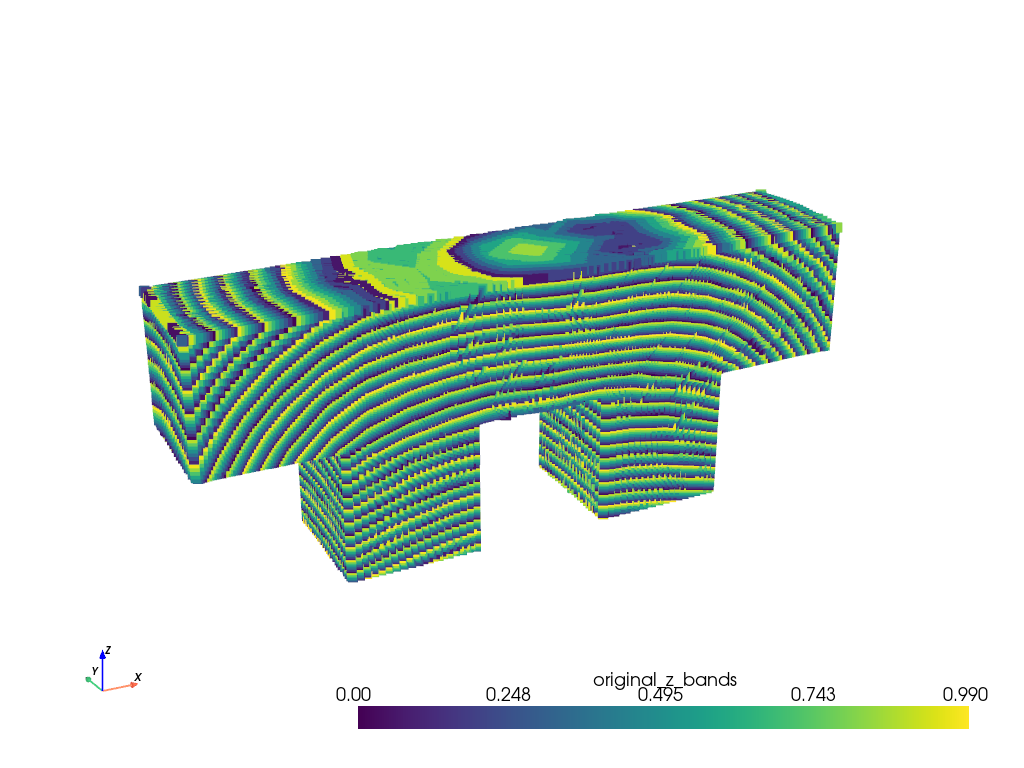

In [21]:
# plot new_gcode_points using pyvista
temp = np.array([point["position"] for point in new_gcode_points])
#temp = np.array(a)
temp = pv.PolyData(temp)
temp.cell_data["rotation"] = np.array([np.rad2deg(point["rotation"]) for point in new_gcode_points])
temp.cell_data["travelling"] = np.array([point["travelling"] for point in new_gcode_points])
temp.cell_data["delta_rotation"] = np.clip(np.array([1] + [np.rad2deg(new_gcode_points[i+1]["rotation"] - new_gcode_points[i]["rotation"]) for i in range(len(new_gcode_points)-1)]), -10, 10)
temp.cell_data["command"] = np.array([point["command"] for point in new_gcode_points])
temp.cell_data["feed"] = np.array([min(point["feed"], 10000) for point in new_gcode_points])
temp.cell_data["original_z"] = np.array([point["original_position"][2] for point in new_gcode_points])
temp.cell_data["original_z_bands"] = temp.cell_data["original_z"] % 1
temp.cell_data["extrusion_multiplier"] = np.array([min(point["extrusion_multiplier"], 15) if point["extrusion_multiplier"] is not None else np.nan for point in new_gcode_points])

temp.extract_cells(np.array([point["command"] for point in new_gcode_points]) == "G01").plot(scalars="original_z_bands", cpos=[-0.5, -1, 0.5], point_size=10)
# .extract_cells(np.array([point["command"] for point in new_gcode_points]) == "G01")

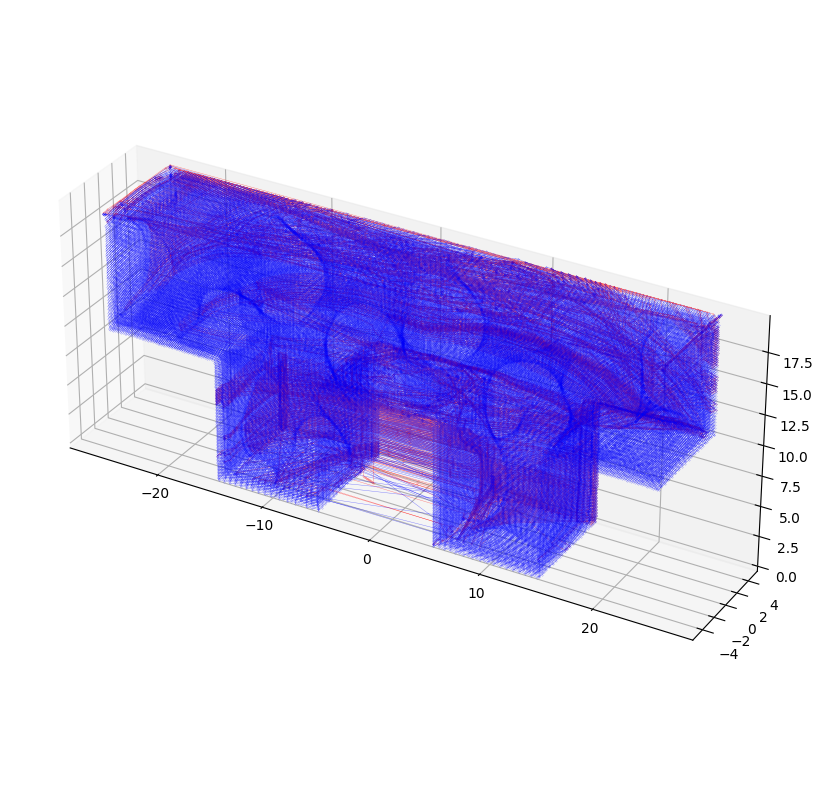

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the gcode
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')
rotation_normalized = temp.cell_data["rotation"] / np.max(np.abs(temp.cell_data["rotation"]),axis=0)
colors = cmap(rotation_normalized)
# for i in np.arange(len(temp.points)-1):
#     ax.plot(
#         [temp.points[i,0],temp.points[i+1,0]],
#         [temp.points[i,1],temp.points[i+1,1]],
#         [temp.points[i,2],temp.points[i+1,2]],
#         c=colors[i],
#         markersize=0.8, linewidth=0.9, marker='.', alpha=0.5)
# plot G00 moves in different color
g00_indices = np.where(temp.cell_data["command"] == "G00")[0]
g01_indices = np.where(temp.cell_data["command"] == "G01")[0]
ax.plot(temp.points[g00_indices,0], temp.points[g00_indices,1], temp.points[g00_indices,2], markersize=0.4, linewidth=0.3, marker=".", alpha=0.5, color="red")
ax.plot(temp.points[g01_indices,0], temp.points[g01_indices,1], temp.points[g01_indices,2], markersize=0.4, linewidth=0.3, marker=".", alpha=0.5, color="blue")
ax.set_box_aspect((np.ptp(temp.points[:,0]), np.ptp(temp.points[:,1]), np.ptp(temp.points[:,2])))
plt.show()